In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.optim as optim
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from collections import Counter

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

# Ładowanie danych i tworzenie datasetu
Wcześniej zostały usunięte przeze mnie manualnie elementy odstające z datasetu

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize((180,180))
    ]
)

In [6]:
dataset_orig = torchvision.datasets.ImageFolder("flowers", transform=transform) # dataset zawierający wszystkie dostępne dane

In [7]:
len(dataset_orig)

4303

In [8]:
dataset_orig.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

## Rozkład klas w zbiorze danych

In [9]:
class_idx, counts = np.unique(dataset_orig.targets, return_counts=True)

In [10]:
y, x = counts, list(dataset_orig.class_to_idx.keys())

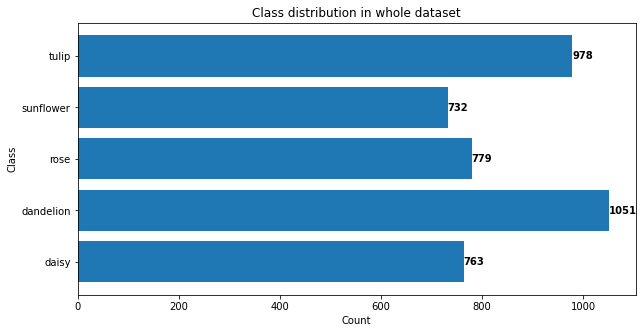

In [11]:
plt.figure(figsize=(10,5))
plt.barh(y=x, width=y)
plt.title('Class distribution in whole dataset')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(y):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

Zbiór danych nie jest dobrze zbalansowany.

## Podział zbioru danych na treningowy i testowy

In [12]:
train_size_orig = int(0.7 * len(dataset_orig))
test_size = len(dataset_orig) - train_size_orig
trainset_orig, testset = random_split(dataset_orig, [train_size_orig, test_size])

In [13]:
len(trainset_orig)/len(dataset_orig), len(testset)/len(dataset_orig)

(0.6999767603997211, 0.3000232396002789)

### Rozkład klas w zbiorze treningowym

In [14]:
class_idx, counts = np.unique([trainset_orig[i][1] for i in range(len(trainset_orig))], return_counts=True)

In [15]:
y, x = counts, list(dataset_orig.class_to_idx.keys())

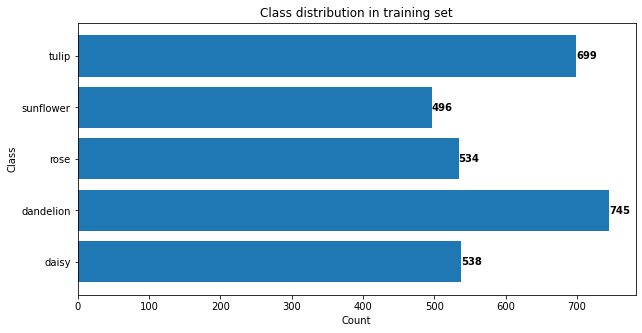

In [16]:
plt.figure(figsize=(10,5))
plt.barh(y=x, width=y)
plt.title('Class distribution in training set')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(y):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

## Wydzielenie zbioru walidacyjnego ze zbioru treningowego

In [17]:
train_size = int(0.8 * len(trainset_orig))
val_size = len(trainset_orig) - train_size
trainset, valset = random_split(trainset_orig, [train_size, val_size])

In [18]:
len(trainset)/len(trainset_orig), len(valset)/len(trainset_orig)

(0.799800796812749, 0.20019920318725098)

In [19]:
BATCH_SIZE = 32
NUM_WORKERS = 2

In [20]:
trainloader_orig = torch.utils.data.DataLoader(trainset_orig, batch_size=BATCH_SIZE, num_workers=2, shuffle=True) # pełny zbiór danych
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True) # zbiór treningowy (56% całego zbioru)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True) # zbiór walidacyjny (14% całego zbioru)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False) # zbiór testowy (30% całego zbioru)

In [21]:
next(iter(trainloader))[0][0].shape # rozmiar pojedynczego obrazu

torch.Size([3, 180, 180])

## Wizualizacja kilku zdjęć ze zbioru

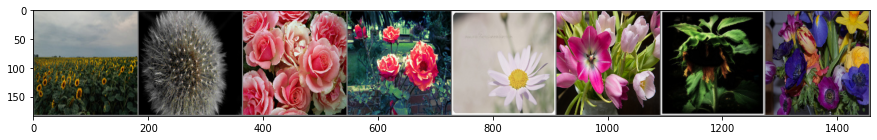

GroundTruth:  sunflower dandelion  rose  rose daisy tulip sunflower tulip


In [22]:
def imshow(img):
    img = img / 2 + 0.5 # denormalizacja obrazu
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
random_images, random_labels = dataiter.next()
random_images = random_images[:8]

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(random_images))
print('GroundTruth: ', ' '.join('%5s' % dataset_orig.classes[random_labels[j]] for j in range(8)))

# Konwolucyjna sieć neuronowa

### Funkcje pomocnicze

In [23]:
def get_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in loader:

            images, labels = data
            images = images.to(device)

            outputs = model(images).cpu()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [24]:
def plot_training(iters, losses, train_acc, test_acc=None):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if test_acc:
        plt.plot(iters, test_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')

    plt.show()

In [25]:
class FlowersClassifier(nn.Module):
    def __init__(self, n_in_channels, n_out_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=n_in_channels, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # -> 90x90x32
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # -> 45x45x64
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # -> 22x22x128
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool4 = nn.MaxPool2d(2, 2) # -> 11x11x256
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 11 * 11, 128)
        self.drop1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(64, n_out_classes)

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))

        x = torch.flatten(x, 1)
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [26]:
flower_classifier = FlowersClassifier(n_in_channels=3, n_out_classes=5).to(device)
flower_classifier

FlowersClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

# Trening klasyfikatora i strojenie hiperparametrów
Trening na części zbioru treningowego oraz ewaluacja przy pomocy zbioru walidacyjnego

In [27]:
LR = 0.0005
EPOCHS = 20
WEIGHT_DECAY = 0.0001

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [29]:
iters = []
losses = []
train_acc_ls = []
val_acc_ls = []

for epoch in range(EPOCHS):
    flower_classifier.train()
    epoch_losses = []
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = flower_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    iters.append(epoch)
    loss_mean = np.array(epoch_losses).mean()
    losses.append(loss_mean)

    train_acc = get_accuracy(flower_classifier, trainloader)
    val_acc = get_accuracy(flower_classifier, valloader)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3} train_acc: {100*train_acc:.3}% val_acc: {100*val_acc:.3}%")

print('Finished Training')

[1/20] loss: 1.94 train_acc: 49.7% val_acc: 48.8%
[2/20] loss: 1.73 train_acc: 52.3% val_acc: 50.4%
[3/20] loss: 1.58 train_acc: 56.5% val_acc: 55.9%
[4/20] loss: 1.4 train_acc: 61.1% val_acc: 58.0%
[5/20] loss: 1.32 train_acc: 62.4% val_acc: 60.4%
[6/20] loss: 1.19 train_acc: 61.1% val_acc: 59.7%
[7/20] loss: 1.18 train_acc: 67.5% val_acc: 61.0%
[8/20] loss: 1.1 train_acc: 67.0% val_acc: 64.5%
[9/20] loss: 1.03 train_acc: 71.2% val_acc: 67.7%
[10/20] loss: 1.01 train_acc: 68.2% val_acc: 65.7%
[11/20] loss: 0.979 train_acc: 72.7% val_acc: 66.0%
[12/20] loss: 0.919 train_acc: 74.7% val_acc: 67.7%
[13/20] loss: 0.893 train_acc: 73.9% val_acc: 66.8%
[14/20] loss: 0.853 train_acc: 75.5% val_acc: 65.7%
[15/20] loss: 0.825 train_acc: 78.0% val_acc: 70.1%
[16/20] loss: 0.8 train_acc: 79.2% val_acc: 69.0%
[17/20] loss: 0.697 train_acc: 82.9% val_acc: 73.0%
[18/20] loss: 0.704 train_acc: 83.5% val_acc: 73.6%
[19/20] loss: 0.67 train_acc: 83.0% val_acc: 70.3%
[20/20] loss: 0.661 train_acc: 86.8%

#### Wizualizacja przebiegu treningu

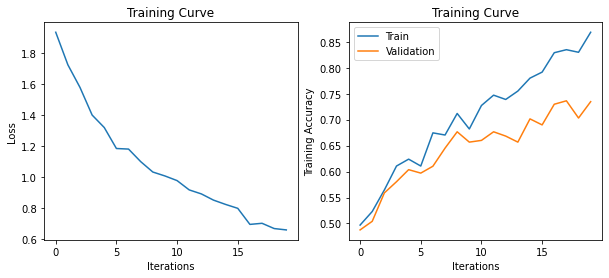

In [30]:
plot_training(iters, losses, train_acc_ls, val_acc_ls)

Widoczne są objawy przeuczenia modelu - skuteczność modelu dla zbioru treningowego ciągle rośnie, natomiast skuteczność modelu dla zbioru walidacyjnego zatrzymuje się gdzieś na granicy 75%.

## Ostateczny trening modelu
Trening na całym zbiorze treningowym

In [31]:
flower_classifier = FlowersClassifier(n_in_channels=3, n_out_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [32]:
iters = []
losses = []
train_acc_ls = []

for epoch in range(EPOCHS):
    flower_classifier.train()
    epoch_losses = []
    for i, data in enumerate(trainloader_orig, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = flower_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    iters.append(epoch)
    loss_mean = np.array(epoch_losses).mean()
    losses.append(loss_mean)

    train_acc = get_accuracy(flower_classifier, trainloader_orig)
    train_acc_ls.append(train_acc)

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3} train_acc: {100*train_acc:.3}%")

print('Finished Training')

[1/20] loss: 1.86 train_acc: 53.1%
[2/20] loss: 1.52 train_acc: 55.1%
[3/20] loss: 1.41 train_acc: 60.3%
[4/20] loss: 1.29 train_acc: 63.9%
[5/20] loss: 1.21 train_acc: 62.0%
[6/20] loss: 1.13 train_acc: 66.1%
[7/20] loss: 1.06 train_acc: 68.3%
[8/20] loss: 1.04 train_acc: 70.8%
[9/20] loss: 0.991 train_acc: 73.8%
[10/20] loss: 0.929 train_acc: 73.9%
[11/20] loss: 0.888 train_acc: 75.4%
[12/20] loss: 0.835 train_acc: 77.2%
[13/20] loss: 0.779 train_acc: 79.6%
[14/20] loss: 0.767 train_acc: 80.6%
[15/20] loss: 0.833 train_acc: 80.5%
[16/20] loss: 0.737 train_acc: 82.6%
[17/20] loss: 0.676 train_acc: 85.3%
[18/20] loss: 0.628 train_acc: 85.2%
[19/20] loss: 0.62 train_acc: 87.3%
[20/20] loss: 0.568 train_acc: 89.4%
Finished Training


#### Wizualizacja przebiegu treningu

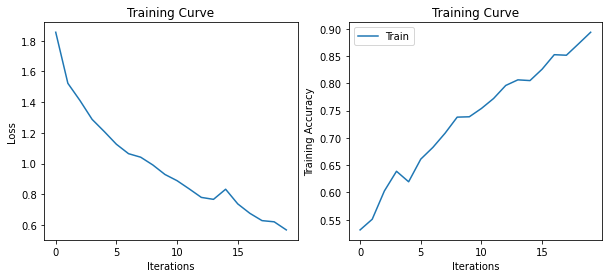

In [33]:
plot_training(iters, losses, train_acc_ls)

Trening na całym zbiorze treningowym skutkuje porawą skuteczności modelu, ze względu na więcej dostępnych danych.

#### Zapisanie modelu

In [34]:
torch.save(flower_classifier.state_dict(), "./flower_classifier.pth")

## Ewaluacja modelu na zbiorze testowym

In [35]:
correct_pred = {classname: 0 for classname in dataset_orig.classes}
total_pred = {classname: 0 for classname in dataset_orig.classes}
y_pred = []
y_true = []

with torch.no_grad():
    flower_classifier.eval()
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = flower_classifier(images).cpu()
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[dataset_orig.classes[label]] += 1
            total_pred[dataset_orig.classes[label]] += 1

        y_pred.extend(predictions)
        y_true.extend(labels)

y_true = [dataset_orig.classes[i] for i in y_true]
y_pred = [dataset_orig.classes[i] for i in y_pred]

# skuteczność dla każdej klasy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class daisy is: 64.4 %
Accuracy for class dandelion is: 88.2 %
Accuracy for class rose  is: 60.8 %
Accuracy for class sunflower is: 74.6 %
Accuracy for class tulip is: 69.5 %


Text(0, 0.5, 'Class')

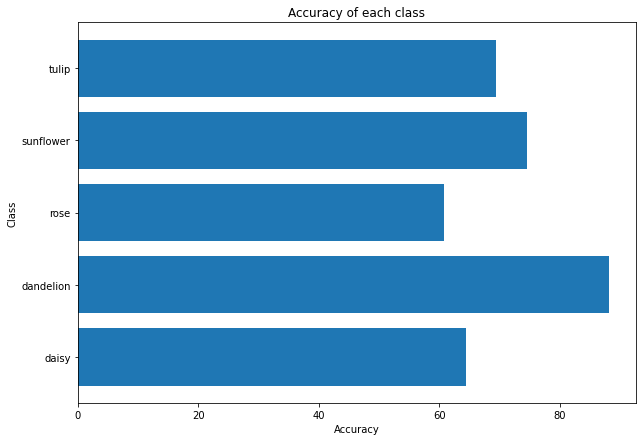

In [36]:
plt.figure(figsize=(10,7))
plt.barh(list(correct_pred.keys()), [100 * float(v) / total_pred[k] for k, v in correct_pred.items()], align='center')
plt.title('Accuracy of each class')
plt.xlabel('Accuracy')
plt.ylabel('Class')

In [37]:
def plot_cms(y_true, y_pred):
    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred, labels=dataset_orig.classes), display_labels=dataset_orig.classes)
    cm.plot()
    plt.show()

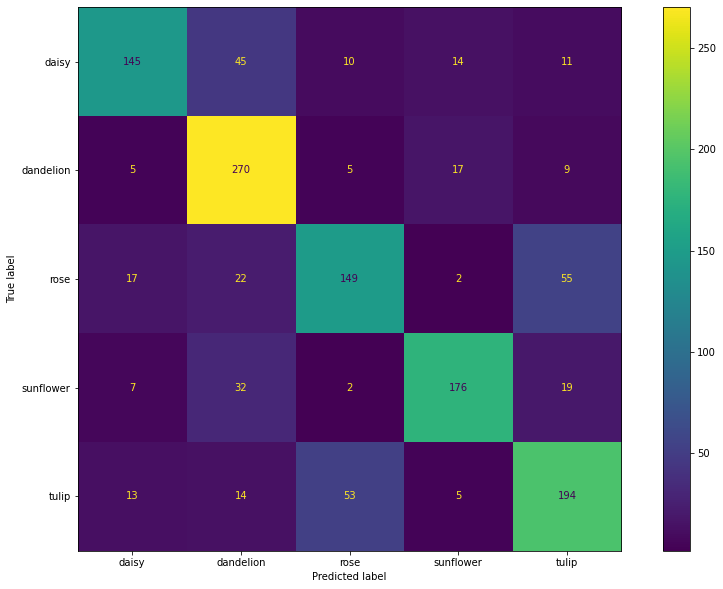

In [38]:
plot_cms(y_true, y_pred)

In [39]:
print(classification_report(y_true, y_pred, labels=dataset_orig.classes))

              precision    recall  f1-score   support

       daisy       0.78      0.64      0.70       225
   dandelion       0.70      0.88      0.78       306
        rose       0.68      0.61      0.64       245
   sunflower       0.82      0.75      0.78       236
       tulip       0.67      0.70      0.68       279

    accuracy                           0.72      1291
   macro avg       0.73      0.72      0.72      1291
weighted avg       0.73      0.72      0.72      1291



##### Podsumowanie treningu
Model często myli:
- Róże z tulipanami i vice versa - Może to być spowodowane podobieństwem kwiatów, szczególnie ich dominujących kolorów
- Stokrotki z mniszkami - Zbiór danych zawiera zdjęcia mniszków w trakcie rozkwitu jak i nie. Mniszki w trakcie rozkwitu mają podobnie jak stokrotki dominujący kolor biały oraz podobny kształt, co może być źródłem pomyłek modelu
- Słoneczniki z mniszkami - Z kolei mniszki przed rozkwitem mają bardzo podobny kolor do słoneczników.

Model z dobrą skutecznością klasyfikuje mniszki, gdy na wejściu dostaje zdjęcia mniszków, jednak często też klasyfikuje inne kwiaty jako mniszki. Należy zauważyć, że zdjęć mniszków jest najwięcej w zbiorze treningowym, z czego wynikać może dobra skuteczność klasyfikacji tej klasy.<br>
Model dość rzadko myli się co do słoneczników, prawdopodobnie dlatego, że nie są one podobne do żadnych innych kwiatów ze zbioru oprócz do mniszków przed fazą rozkwitu.<br>
Dla pozostałych klas model osiąga przeciętne wyniki.

# Generowanie nowych zdjęć

In [40]:
trainset_orig_counter = Counter([trainset_orig[i][1] for i in range(len(trainset_orig))])

In [41]:
trainset_orig_counter

Counter({4: 699, 2: 534, 0: 538, 3: 496, 1: 745})

In [42]:
max_count = np.array(list(trainset_orig_counter.values())).max()

In [43]:
to_gen_dict = dict()
for classname in dataset_orig.classes:
    to_gen_dict[classname] = max_count - trainset_orig_counter[dataset_orig.class_to_idx[classname]]

In [44]:
to_gen_dict # Liczba zdjęć do wygenerowania dla każdej klasy

{'daisy': 207, 'dandelion': 0, 'rose': 211, 'sunflower': 249, 'tulip': 46}

In [45]:
classes_indices_dict = {classname: [] for classname in dataset_orig.classes}
for i, (path, class_idx) in enumerate(dataset_orig.imgs):
    classes_indices_dict[dataset_orig.classes[class_idx]].append(i)

In [46]:
# losowe wybranie indeksów obrazów, które będą przetworzone
to_generate_indices_dict = {classname: [] for classname in dataset_orig.classes}
for classname, indices in classes_indices_dict.items():
    to_generate_indices_dict[classname] = random.sample(classes_indices_dict[classname], k=to_gen_dict[classname])

In [47]:
[len(x) for x in to_generate_indices_dict.values()]

[207, 0, 211, 249, 46]

In [48]:
augmented_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize((180,180))
    ]
)

In [49]:
# generacja obrazów
generated_images = []
generated_images_targets = []
for classname, indices_list in to_generate_indices_dict.items():
    for i in indices_list:
        image = Image.open(dataset_orig.imgs[i][0]).convert("RGB")
        transformed_tensor = augmented_transform(image)
        generated_images.append(transformed_tensor)
        generated_images_targets.append(dataset_orig.class_to_idx[classname])

In [50]:
class AugmentedDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.targets[idx]

        return image, label

In [51]:
augmented_dataset = AugmentedDataset(generated_images, generated_images_targets)

##### Połączenie zbioru treningowego z nowo wygenerowanymi obrazami

In [52]:
trainset_even_orig = ConcatDataset([augmented_dataset, trainset_orig])

## Rozkład klas w nowym zbiorze treningowym

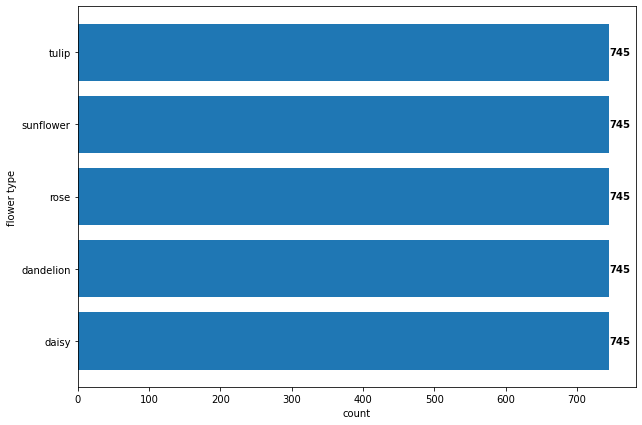

In [53]:
class_idx, counts = np.unique([trainset_even_orig[i][1] for i in range(len(trainset_even_orig))], return_counts=True)
y, x = counts, list(dataset_orig.class_to_idx.keys())
plt.figure(figsize=(10,7))
plt.barh(y=x, width=y)
plt.xlabel('count')
plt.ylabel('flower type')
for i, v in enumerate(y):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

In [54]:
augmented_loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=BATCH_SIZE)

### Wizualizacja kilku przykładowych wygenerowanych zdjęć

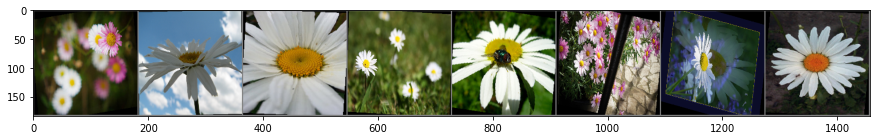

GroundTruth:  daisy daisy daisy daisy daisy daisy daisy daisy


In [55]:
dataiter = iter(augmented_loader)
random_images, random_labels = dataiter.next()
random_images = random_images[:8]
# show images
plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(random_images))
print('GroundTruth: ', ' '.join('%5s' % dataset_orig.classes[random_labels[j]] for j in range(8)))

In [56]:
trainloader_even = torch.utils.data.DataLoader(trainset_even_orig, batch_size=BATCH_SIZE, shuffle=True)

# Trening modelu na nowym zbiorze

In [57]:
flower_classifier = FlowersClassifier(n_in_channels=3, n_out_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [58]:
iters = []
losses = []
train_acc_ls = []

for epoch in range(EPOCHS):
    flower_classifier.train()
    epoch_losses = []
    for i, data in enumerate(trainloader_even, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = flower_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    iters.append(epoch)
    loss_mean = np.array(epoch_losses).mean()
    losses.append(loss_mean)

    train_acc = get_accuracy(flower_classifier, trainloader_even)
    train_acc_ls.append(train_acc)

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3} train_acc: {100*train_acc:.3}%")

print('Finished Training')

[1/20] loss: 1.75 train_acc: 57.3%
[2/20] loss: 1.49 train_acc: 60.8%
[3/20] loss: 1.3 train_acc: 63.1%
[4/20] loss: 1.18 train_acc: 62.3%
[5/20] loss: 1.08 train_acc: 66.7%
[6/20] loss: 1.04 train_acc: 72.5%
[7/20] loss: 0.96 train_acc: 75.1%
[8/20] loss: 0.915 train_acc: 73.1%
[9/20] loss: 0.875 train_acc: 78.7%
[10/20] loss: 0.839 train_acc: 76.9%
[11/20] loss: 0.769 train_acc: 80.0%
[12/20] loss: 0.74 train_acc: 82.0%
[13/20] loss: 0.681 train_acc: 84.4%
[14/20] loss: 0.664 train_acc: 84.3%
[15/20] loss: 0.606 train_acc: 84.9%
[16/20] loss: 0.574 train_acc: 87.6%
[17/20] loss: 0.545 train_acc: 90.1%
[18/20] loss: 0.503 train_acc: 90.6%
[19/20] loss: 0.534 train_acc: 91.3%
[20/20] loss: 0.47 train_acc: 90.8%
Finished Training


## Wizualizacja przebiegu treningu

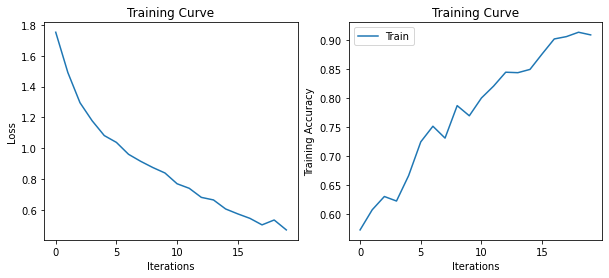

In [59]:
plot_training(iters, losses, train_acc_ls)

### Zapisanie modelu

In [60]:
torch.save(flower_classifier.state_dict(), "./flower_classifier_augmented.pth")

## Ewaluacja na zbiorze testowym

In [61]:
correct_pred = {classname: 0 for classname in dataset_orig.classes}
total_pred = {classname: 0 for classname in dataset_orig.classes}
y_pred = []
y_true = []

with torch.no_grad():
    flower_classifier.eval()
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = flower_classifier(images).cpu()
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[dataset_orig.classes[label]] += 1
            total_pred[dataset_orig.classes[label]] += 1

        y_pred.extend(predictions)
        y_true.extend(labels)

y_true = [dataset_orig.classes[i] for i in y_true]
y_pred = [dataset_orig.classes[i] for i in y_pred]

# skuteczność dla każdej klasy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class daisy is: 67.1 %
Accuracy for class dandelion is: 86.6 %
Accuracy for class rose  is: 63.7 %
Accuracy for class sunflower is: 84.3 %
Accuracy for class tulip is: 76.7 %


Text(0, 0.5, 'Class')

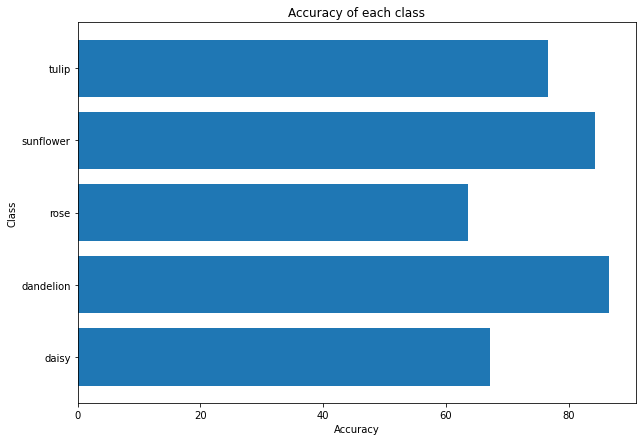

In [62]:
plt.figure(figsize=(10,7))
plt.barh(list(correct_pred.keys()), [100 * float(v) / total_pred[k] for k, v in correct_pred.items()], align='center')
plt.title('Accuracy of each class')
plt.xlabel('Accuracy')
plt.ylabel('Class')

<Figure size 720x504 with 0 Axes>

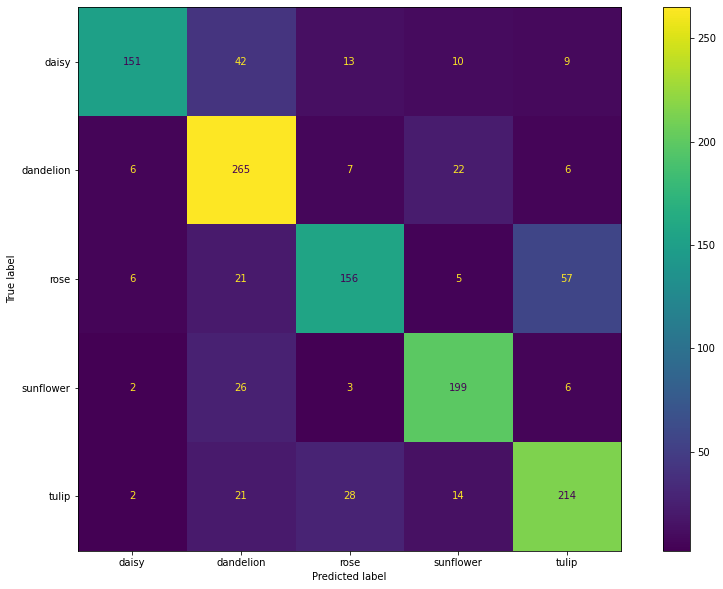

In [63]:
plt.figure(figsize=(10,7))
plot_cms(y_true, y_pred)

In [64]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       daisy       0.90      0.67      0.77       225
   dandelion       0.71      0.87      0.78       306
        rose       0.75      0.64      0.69       245
   sunflower       0.80      0.84      0.82       236
       tulip       0.73      0.77      0.75       279

    accuracy                           0.76      1291
   macro avg       0.78      0.76      0.76      1291
weighted avg       0.77      0.76      0.76      1291



##### Podsumowanie treningu
Model często myli:
 - Mniszki pospolite z pozostałymi kwiatami
 - Róże z tulipanami

Model bardzo rzadko klasyfikował kwiaty poza stokrotkami jako stokrotki, natomiast rozpoznał dość małą ilość stokrotek w zbiorze danych.
Model rozpoznał dużą ilość mniszków w zbiorze danych, ale często też klasyfikował inne kwiaty jako mniszki.
Model najgorzej radzi sobie z różami - szczególnie niska jest wartość metryki recall dla róż, a więc model rozpoznał małą ilość róż w zbiorze danych.
Model całkiem dobrze radzi sobie z klasyfikacją słoneczników.
Model rozpoznaje znaczną część tulipanów w zbiorze, jednak często myli róże z tulipanami przez co niska wartość metryki precision.

# Wnioski i porównanie wyników

- Model wytrenowany na zrównoważonym zbiorze danych osiąga lepsze accuracy dla każdej klasy poza mniszkiem - przez to, że mniszek był zdecydowanie najliczniejszą klasą w niezrównoważonym zbiorze
- Podobnie dla każdej klasy poza mniszkiem model wytrenowany na zrównoważonym zbiorze osiąga znacznie wyższe wartości metryki precision oraz recall - a więc model rzadziej się myli i rozpoznaje poprawnie większą część zdjęć ze zbioru
- Wygenerowanie nowych próbek danych, a tym samym zrównoważenie zbioru danych znacznie poprawiło skutecznoóść modelu